# **🧠 Fake News Detection**

**Problem:**
Fake news spreads rapidly and influences public opinion. Social media platforms and online news aggregators struggle to combat it. This project builds a machine learning model to classify news as Real or Fake based on metadata, using a structured, explainable approach.

**Goal:**
Predict whether a news article is fake or real based on metadata like source, sentiment, author, etc.

**Dataset Source:**
4,000 articles with 24+ columns from both credible and misleading sources.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khushikyad001/fake-news-detection")

print("Path to dataset files:", path)

Path to dataset files: /Users/anitahuang/.cache/kagglehub/datasets/khushikyad001/fake-news-detection/versions/1


## 📊**2. Data Loading and Cleaning**

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/anitahuang/Anita-s-Portfolio/data-science-projects/fake-news-detection/data/fake_news_dataset.csv')
df.head()

,id,title,author,text,state,date_published,source,category,sentiment_score,word_count,...,num_shares,num_comments,political_bias,fact_check_rating,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score,label
0,1,Breaking News 1,Jane Smith,This is the content of article 1. It contains ...,Tennessee,30-11-2021,The Onion,Entertainment,-0.22,1302,...,47305,450,Center,FALSE,1,76,6,0.84,53.35,Fake
1,2,Breaking News 2,Emily Davis,This is the content of article 2. It contains ...,Wisconsin,02-09-2021,The Guardian,Technology,0.92,322,...,39804,530,Left,Mixed,1,1,5,0.85,28.28,Fake
2,3,Breaking News 3,John Doe,This is the content of article 3. It contains ...,Missouri,13-04-2021,New York Times,Sports,0.25,228,...,45860,763,Center,Mixed,0,57,1,0.72,0.38,Fake
3,4,Breaking News 4,Alex Johnson,This is the content of article 4. It contains ...,North Carolina,08-03-2020,CNN,Sports,0.94,155,...,34222,945,Center,TRUE,1,18,10,0.92,32.20,Fake
4,5,Breaking News 5,Emily Davis,This is the content of article 5. It contains ...,California,23-03-2022,Daily Mail,Technology,-0.01,962,...,35934,433,Right,Mixed,0,95,6,0.66,77.70,Real


In [5]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4000 non-null   int64  
 1   title              4000 non-null   object 
 2   author             4000 non-null   object 
 3   text               4000 non-null   object 
 4   state              4000 non-null   object 
 5   date_published     4000 non-null   object 
 6   source             4000 non-null   object 
 7   category           4000 non-null   object 
 8   sentiment_score    4000 non-null   float64
 9   word_count         4000 non-null   int64  
 10  char_count         4000 non-null   int64  
 11  has_images         4000 non-null   int64  
 12  has_videos         4000 non-null   int64  
 13  readability_score  4000 non-null   float64
 14  num_shares         4000 non-null   int64  
 15  num_comments       4000 non-null   int64  
 16  political_bias     4000 

In [6]:
# check null values
df.isnull().sum()

id                   0
title                0
author               0
text                 0
state                0
date_published       0
source               0
category             0
sentiment_score      0
word_count           0
char_count           0
has_images           0
has_videos           0
readability_score    0
num_shares           0
num_comments         0
political_bias       0
fact_check_rating    0
is_satirical         0
trust_score          0
source_reputation    0
clickbait_score      0
plagiarism_score     0
label                0
dtype: int64

In [8]:
# view summary statistics for numerical variables
df.describe()

,id,sentiment_score,word_count,char_count,has_images,has_videos,readability_score,num_shares,num_comments,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score
count,4000.000000,4000.000000,4000.000000,4000.0000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000
mean,2000.500000,-0.000645,795.655750,4277.0680,0.49650,0.484500,54.764595,25144.596750,489.870250,0.497000,49.960750,5.54925,0.494447,50.598110
std,1154.844867,0.574768,406.373871,2186.2073,0.50005,0.499822,14.404027,14387.537467,287.435733,0.500054,29.467911,2.87422,0.289138,28.932298
min,1.000000,-1.000000,100.000000,500.0000,0.00000,0.000000,30.020000,39.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.040000
25%,1000.750000,-0.490000,445.750000,2358.7500,0.00000,0.000000,42.480000,12781.750000,238.000000,0.000000,24.000000,3.00000,0.240000,25.915000
50%,2000.500000,-0.010000,793.000000,4287.0000,0.00000,0.000000,54.235000,25308.500000,483.000000,0.000000,50.000000,6.00000,0.490000,51.480000
75%,3000.250000,0.510000,1150.000000,6206.5000,1.00000,1.000000,67.215000,37453.500000,741.000000,1.000000,76.000000,8.00000,0.740000,75.580000
max,4000.000000,1.000000,1500.000000,7996.0000,1.00000,1.000000,79.980000,50000.000000,1000.000000,1.000000,100.000000,10.00000,1.000000,99.950000


# **📊 3. Exploratory Data Analysis (EDA)**

In this section, we will analyze distributions, class balance, and relationships (e.g., sentiment_score vs. label, source_reputation vs. is_satirical) to identify predictive signals.

### **🔍 Results Summary**

**Label Distribution:**
* Balanced — 50.65% Fake, 49.35% Real.

**Numerical Features:**
* Overlapping distributions.
* Fake-skewed: is_satirical, clickbait_score, plagiarism_score.
* Real-skewed: source_reputation, trust_score.

**Categorical Features:**
* Entertainment: 54% Fake
* Center bias: 53% Fake
* BBC: 57.5% Fake
* CNN: 52.9% Real

**Scatter (Sentiment vs Clickbait):**
* No clear clusters — supports non-linear modeling.

**Correlations:**
* Very weak (mostly 0.00–0.03) — patterns likely non-linear or interaction-based.

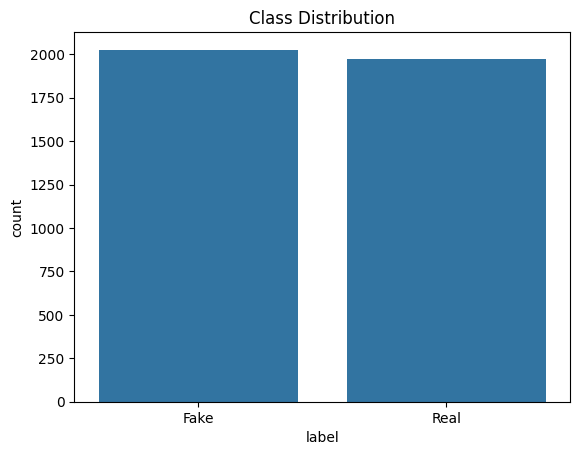

In [9]:
# Plot Fake vs Real
sns.countplot(data=df, x='label')
plt.title('Class Distribution')
plt.show()

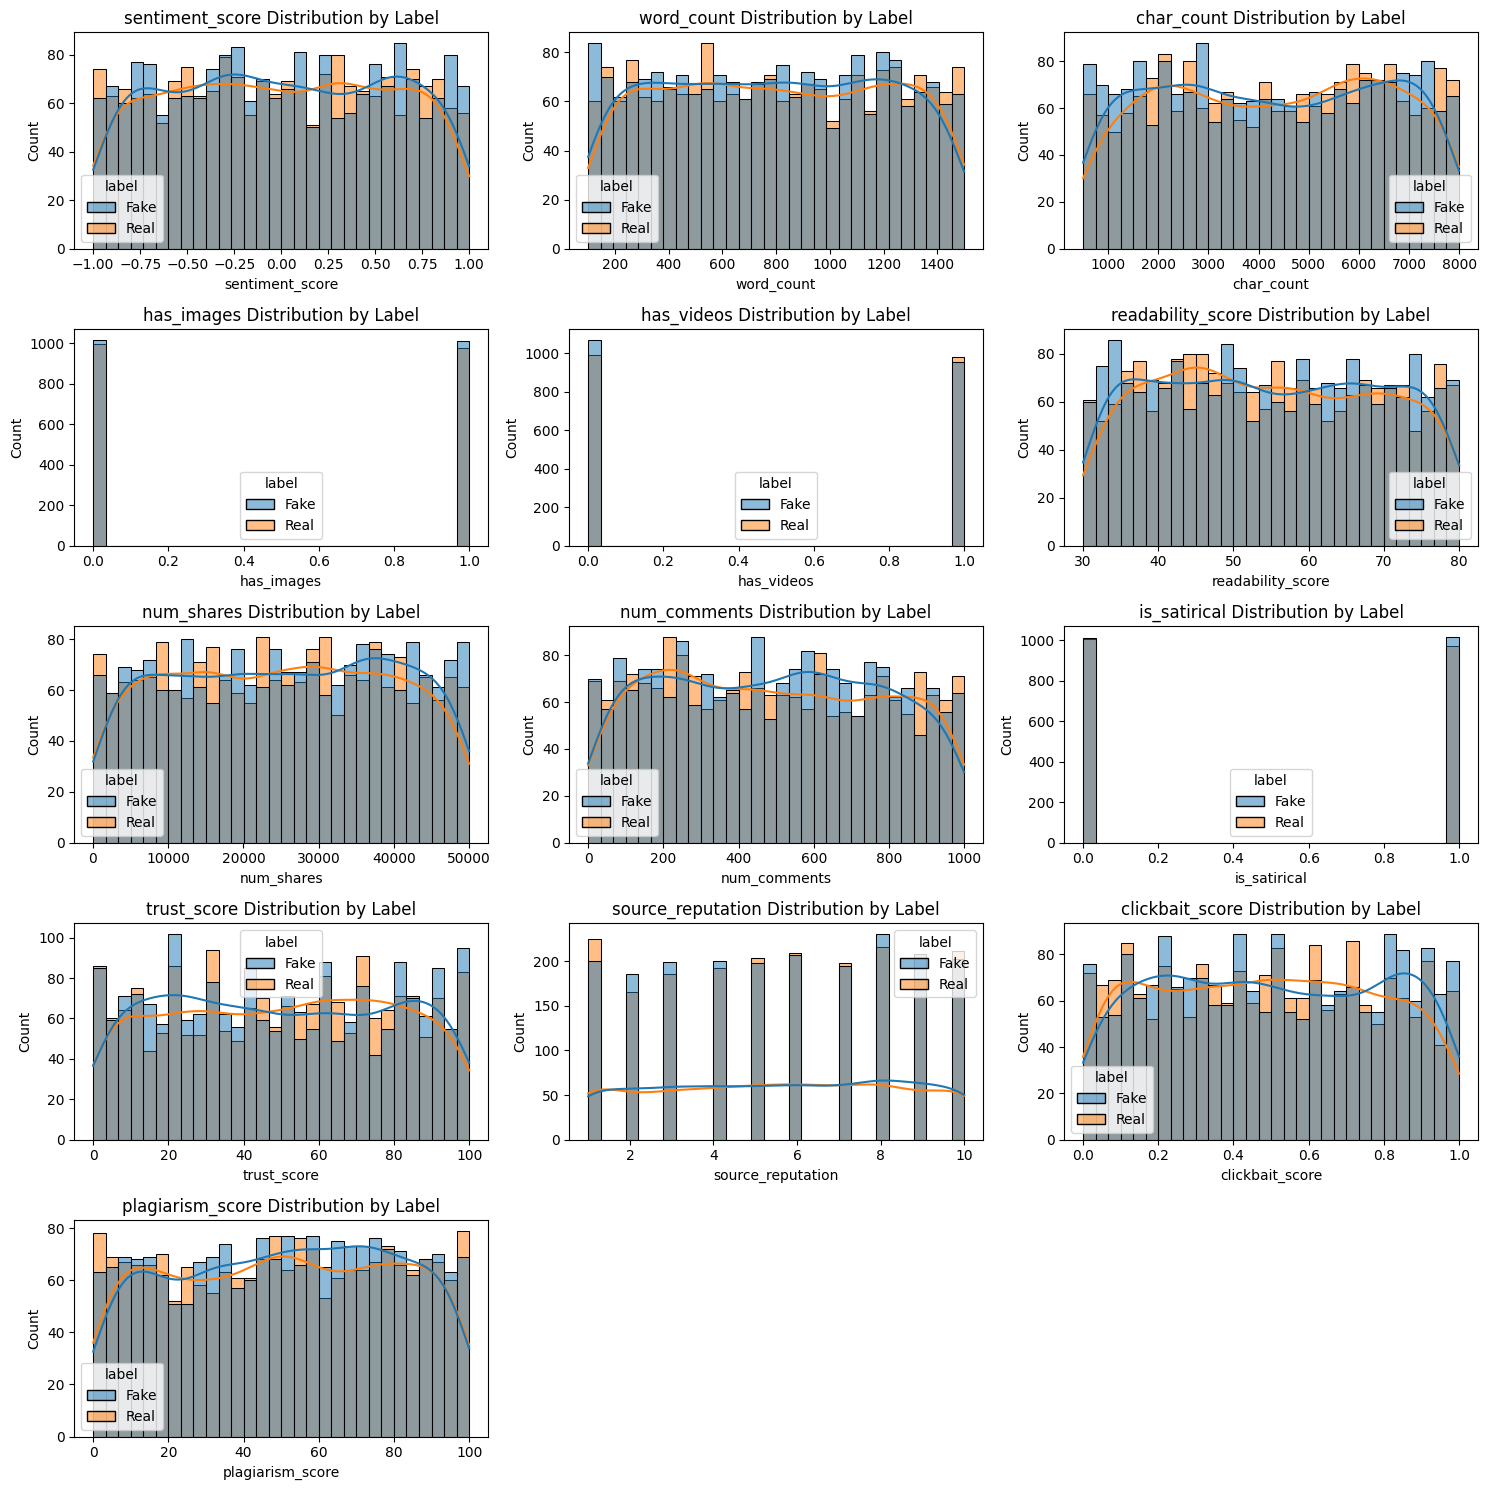

In [10]:
# Numerical features distribution
numerical_cols = ['sentiment_score', 'word_count', 'char_count', 'has_images', 'has_videos', 
                  'readability_score', 'num_shares', 'num_comments', 'is_satirical', 
                  'trust_score', 'source_reputation', 'clickbait_score', 'plagiarism_score']
plt.figure(figsize=(15, 15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data=df, x=col, hue='label', bins=30, kde=True if col not in ['has_images', 'has_videos', 'is_satirical'] else False)
    plt.title(f'{col} Distribution by Label')
plt.tight_layout()
plt.show()

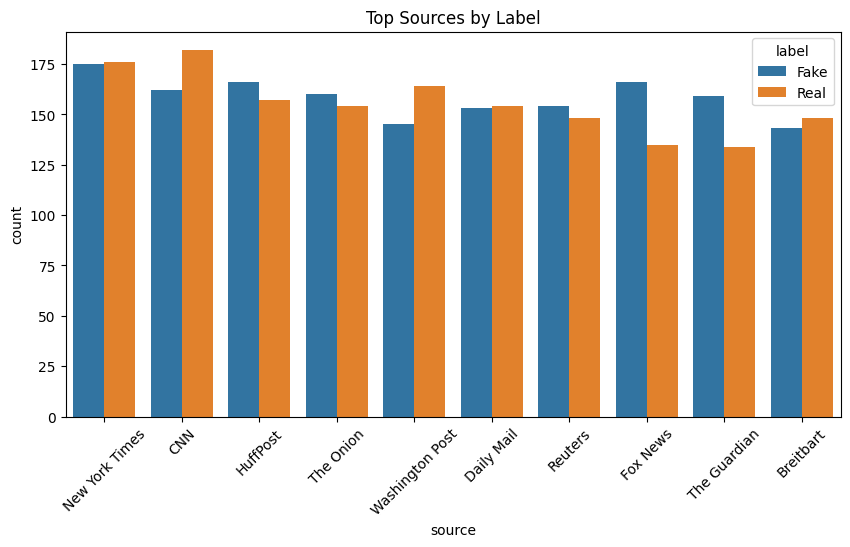

In [11]:
# Top Sources by label
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='source', hue='label', order=df['source'].value_counts().iloc[:10].index)
plt.title('Top Sources by Label')
plt.xticks(rotation=45)
plt.show()

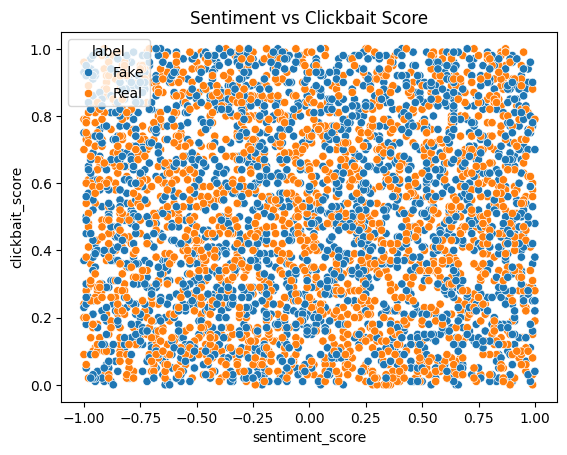

In [12]:
# Sentiment vs Clickbait
sns.scatterplot(data=df, x='sentiment_score', y='clickbait_score', hue='label')
plt.title('Sentiment vs Clickbait Score')
plt.show()

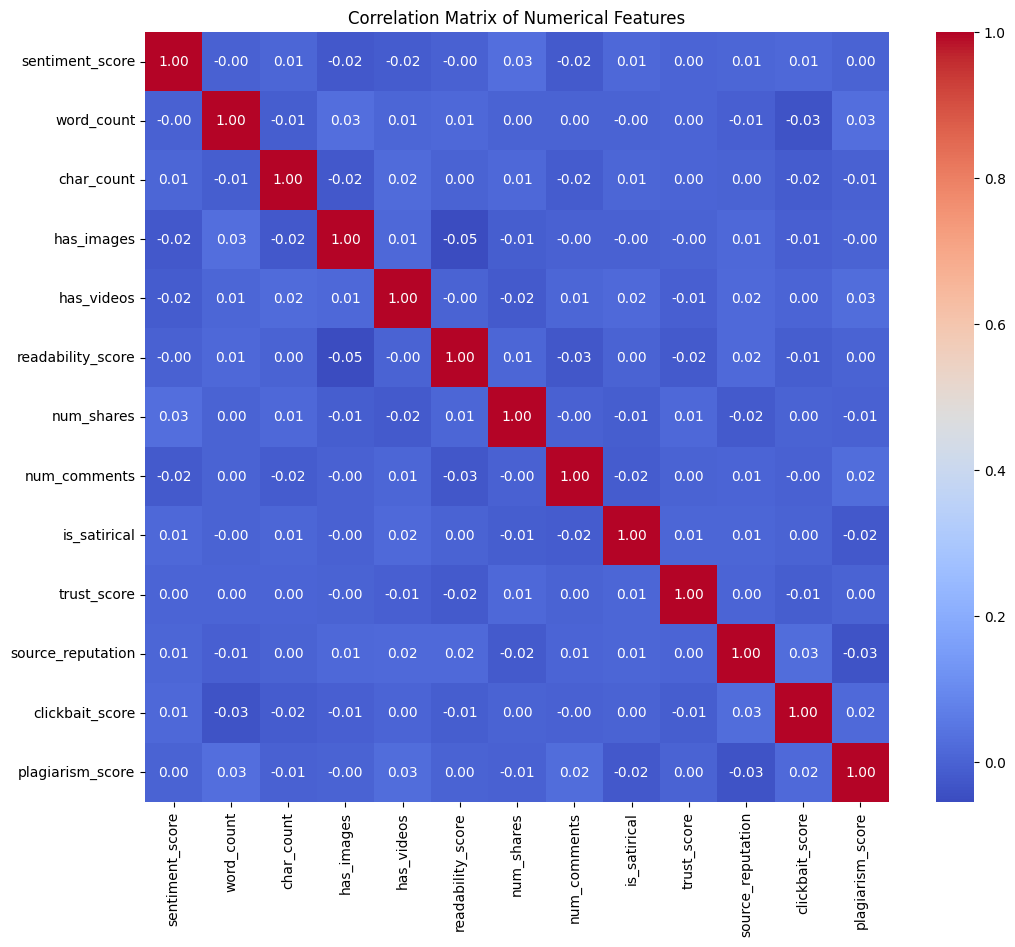

In [15]:
# Correlation Matrix
numerical_df = df[numerical_cols]
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [13]:
# Categorical features 
categorical_cols = ['category', 'political_bias', 'fact_check_rating', 'state', 'source']
for col in categorical_cols:
    print(f"\n{col} vs. Label:\n", pd.crosstab(df[col], df['label'], normalize='index').head(10)) # Top 10 for brevity


category vs. Label:
 label              Fake      Real
category                         
Business       0.504144  0.495856
Entertainment  0.540284  0.459716
Health         0.494964  0.505036
Politics       0.496241  0.503759
Sports         0.512422  0.487578
Technology     0.492958  0.507042

political_bias vs. Label:
 label               Fake      Real
political_bias                    
Center          0.530566  0.469434
Left            0.498895  0.501105
Right           0.490137  0.509863

fact_check_rating vs. Label:
 label                  Fake      Real
fact_check_rating                    
FALSE              0.520089  0.479911
Mixed              0.495627  0.504373
TRUE               0.503894  0.496106

state vs. Label:
 label              Fake      Real
state                            
Arizona        0.456989  0.543011
California     0.511111  0.488889
Florida        0.459091  0.540909
Georgia        0.485549  0.514451
Illinois       0.517588  0.482412
Indiana        0.451456  

# **🧹 4. Preprocessing**

The goal of this next section is to transform the dataset into a model-ready format. This will be achieved by:
* Removing irrelevant columns (id)
* Extracting NLP signals from title and text via TF-IDF
* One-hot encoding key categorical metadata fields
* Converting date_published into a numeric feature (days_since)
* Normalizing numerical features with StandardScaler
* Encoding target labels as binary (Real = 0, Fake = 1)

### 📊 Results
**Shape:** 
* (4,000, 256) — 14 scaled numericals, 200 TF-IDF (title + text), ~41 one-hot, 1 target.

**Head:**
* Numericals: Z-scored (mean ≈ 0, std ≈ 1)
* Categoricals: Binary columns (e.g., source_CNN)
* Text: Embedded via TF-IDF into sparse signal columns

**Summary:**
* Final dataset is fully numeric and model-ready — optimized for training classification models.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

In [17]:
# Step 1: Drop irrelevant column
df.drop(columns=['id'], inplace=True)

In [19]:
# Step 2: TF-IDF on title and text
def apply_tfidf(series, prefix, max_features=100):
    tfidf = TfidfVectorizer(max_features=max_features, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(series.fillna("")).toarray()
    return pd.DataFrame(tfidf_matrix, columns=[f"{prefix}_tfidf_{i}" for i in range(max_features)])

title_tfidf = apply_tfidf(df['title'], 'title')
text_tfidf = apply_tfidf(df['text'], 'text')

df = pd.concat([df.drop(columns=['title', 'text']), title_tfidf, text_tfidf], axis=1)

In [20]:
# Step 3: One-hot encode categorical metadata
metadata_cols = ['category', 'political_bias', 'fact_check_rating', 'state', 'source']
df = pd.get_dummies(df, columns=metadata_cols, drop_first=True)

In [21]:
# Step 4: Convert date to numerical "days since" value
df['date_published'] = pd.to_datetime(df['date_published'], errors='coerce')
df['days_since'] = (df['date_published'] - df['date_published'].min()).dt.days
df.drop(columns=['date_published'], inplace=True)

In [22]:
# Step 5: Normalize numerical features
numeric_cols = [
    'sentiment_score', 'word_count', 'char_count', 'has_images', 'has_videos',
    'readability_score', 'num_shares', 'num_comments', 'is_satirical',
    'trust_score', 'source_reputation', 'clickbait_score', 'plagiarism_score', 'days_since'
]

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [23]:
# Step 6: Encode target
df['label'] = LabelEncoder().fit_transform(df['label'])  # 0 = Real, 1 = Fake

# Final Check
print("✅ Preprocessed Shape:", df.shape)
print("\n🔍 Preview of Preprocessed Data:\n")
print(df.head())

✅ Preprocessed Shape: (4000, 256)

🔍 Preview of Preprocessed Data:

         author  sentiment_score  word_count  char_count  has_images  \
0    Jane Smith        -0.381689    1.246162    0.362743   -0.993024   
1   Emily Davis         1.601968   -1.165712   -0.711398    1.007025   
2      John Doe         0.436135   -1.397055    0.744273   -0.993024   
3  Alex Johnson         1.636769   -1.576715   -1.579219    1.007025   
4   Emily Davis        -0.016278    0.409389   -1.459362    1.007025   

   has_videos  readability_score  num_shares  num_comments  is_satirical  ...  \
0   -0.969466           0.792614    1.540442     -0.138727      1.006018  ...   
1   -0.969466          -0.948784    1.019023      0.139630      1.006018  ...   
2    1.031496          -1.716720    1.439996      0.950348     -0.994018  ...   
3   -0.969466           1.416129    0.631000      1.583612      1.006018  ...   
4   -0.969466          -0.754369    0.750007     -0.197879     -0.994018  ...   

   source_Fo

# **🧱 5. Feature Engineering**

Goal: Enrich the preprocessed dataset with high-signal, derived features that capture hidden patterns not obvious from raw or one-hot encoded data.

### 📊 Results

**Shape:** 
* (4,000, 268) — 12 new features added to the preprocessed dataset.

**Head:** 
* All new columns scaled; values show variance across samples.

**Histograms:**
* Strong signal: credibility_composite, clickbait_vs_credibility — show visible separation between Fake and Real.
* Moderate signal: text_sentiment_consistency, readability_squared, media_richness.
* Limited utility: title_length, text_entropy, engagement_ratio, shares_to_length — distributions collapsed or near-constant.

In [25]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from textblob import TextBlob

In [26]:
# ---- Step 0: Drop high-cardinality column ----
df = df.drop(columns=['author'])

In [27]:
# ---- Step 1: Title Length (TF-IDF proxy) ----
#  Captures potential clickbait pattern through short, attention-grabbing headlines.
df['title_length'] = df[[col for col in df.columns if 'title_tfidf' in col]].sum(axis=1)
df['title_length'] = StandardScaler().fit_transform(df[['title_length']])

In [28]:
# ---- Step 2: Text Sentiment Consistency ----
# Measures how aligned a text’s overall tone is with its calculated sentiment to detect tone manipulation.
df['text_sentiment_consistency'] = df['sentiment_score'].apply(
    lambda x: np.std([TextBlob(str(x)).sentiment.polarity, x])
)
df['text_sentiment_consistency'] = StandardScaler().fit_transform(df[['text_sentiment_consistency']])

In [29]:
# ---- Step 3: Engagement Ratio ----
# Highlights virality by comparing shares to comments, often inflated in fake news.
df['engagement_ratio'] = df['num_shares'] / (df['num_comments'] + 1)  # +1 to avoid div by 0
df['engagement_ratio'] = StandardScaler().fit_transform(df[['engagement_ratio']])

In [30]:
# ---- Step 4: Credibility Composite ----
# A unified score of trustworthiness and source reputation to simplify credibility modeling.
df['credibility_composite'] = (df['trust_score'] + df['source_reputation']) / 2
df['credibility_composite'] = StandardScaler().fit_transform(df[['credibility_composite']])

In [ ]:
# ---- Step 5: TF-IDF Entropy (Title + Text) ----
# Identifies whether few dominant words drive the headline, common in sensational content.
# Measures vocabulary diversity — fake news may use repetitive or focused language.
def compute_entropy(row):
    probs = row[row > 0]
    probs = probs / probs.sum()
    return -(probs * np.log2(probs + 1e-9)).sum()

title_tfidf_cols = [col for col in df.columns if 'title_tfidf' in col]
text_tfidf_cols = [col for col in df.columns if 'text_tfidf' in col]

df['title_entropy'] = df[title_tfidf_cols].apply(compute_entropy, axis=1)
df['text_entropy'] = df[text_tfidf_cols].apply(compute_entropy, axis=1)
df[['title_entropy', 'text_entropy']] = StandardScaler().fit_transform(df[['title_entropy', 'text_entropy']])

In [ ]:
# ---- Step 6: Sentiment Polarity Buckets (Categorical) ----
# Discretizes sentiment to capture emotional tone shifts across classes.
df['sentiment_bucket'] = pd.cut(df['sentiment_score'], bins=[-1, -0.3, 0.3, 1], labels=['Negative', 'Neutral', 'Positive'])
df = pd.get_dummies(df, columns=['sentiment_bucket'], drop_first=True)

In [ ]:
# ---- Step 7: Readability Complexity Features ----
# Emphasizes outliers in text complexity, which can hint at manipulation.
# Highlights overly simple content often associated with fake or misleading news.
df['readability_squared'] = df['readability_score'] ** 2
df['readability_inverse'] = 1 / (df['readability_score'] + 1e-5)
df[['readability_squared', 'readability_inverse']] = StandardScaler().fit_transform(
    df[['readability_squared', 'readability_inverse']]
)

In [ ]:
# ---- Step 8: Shares-to-Length Ratio ----
#  Flags articles with unusually high virality given their length — suspicious signal.
df['shares_to_length'] = df['num_shares'] / (df['word_count'] + 1)
df['shares_to_length'] = StandardScaler().fit_transform(df[['shares_to_length']])

In [ ]:
# ---- Step 9: Media Richness (Image + Video Binary) ----
# Aggregates visual elements (images/videos), commonly overused in fake articles.
df['media_richness'] = df['has_images'] + df['has_videos']
df['media_richness'] = StandardScaler().fit_transform(df[['media_richness']])

In [37]:
# ---- Step 10: Clickbait vs Credibility Interaction ----
# Captures contradiction when a credible source publishes a highly clickbaity article.
df['clickbait_vs_credibility'] = df['clickbait_score'] * df['credibility_composite']
df['clickbait_vs_credibility'] = StandardScaler().fit_transform(df[['clickbait_vs_credibility']])

In [ ]:
# ---- Output Stats ----
print("✅ Engineered Shape:", df.shape)
print("\n🔍 Preview of Engineered Features:\n", df[['title_length', 'text_sentiment_consistency', 
      'engagement_ratio', 'credibility_composite', 'title_entropy', 'text_entropy', 
      'shares_to_length', 'media_richness', 'clickbait_vs_credibility']].head())

✅ Engineered Shape: (4000, 268)

🔍 Preview of Engineered Features:
    title_length  text_sentiment_consistency  engagement_ratio  \
0      0.158478                   -0.966180          0.055186   
1      0.158478                    1.470444          0.019119   
2      0.158478                   -0.857464          0.012835   
3      0.158478                    1.539934         -0.007090   
4      0.158478                   -1.695823          0.020767   

   credibility_composite  title_entropy  text_entropy  shares_to_length  \
0               0.734486       0.158478      0.155131          0.013244   
1              -1.307771       0.158478      0.155131         -0.160978   
2              -0.948679       0.158478      0.155131         -0.096677   
3               0.327483       0.158478      0.155131         -0.032125   
4               1.189638       0.158478      0.155131          0.009328   

   media_richness  clickbait_vs_credibility  
0       -1.379582                  0.867372 

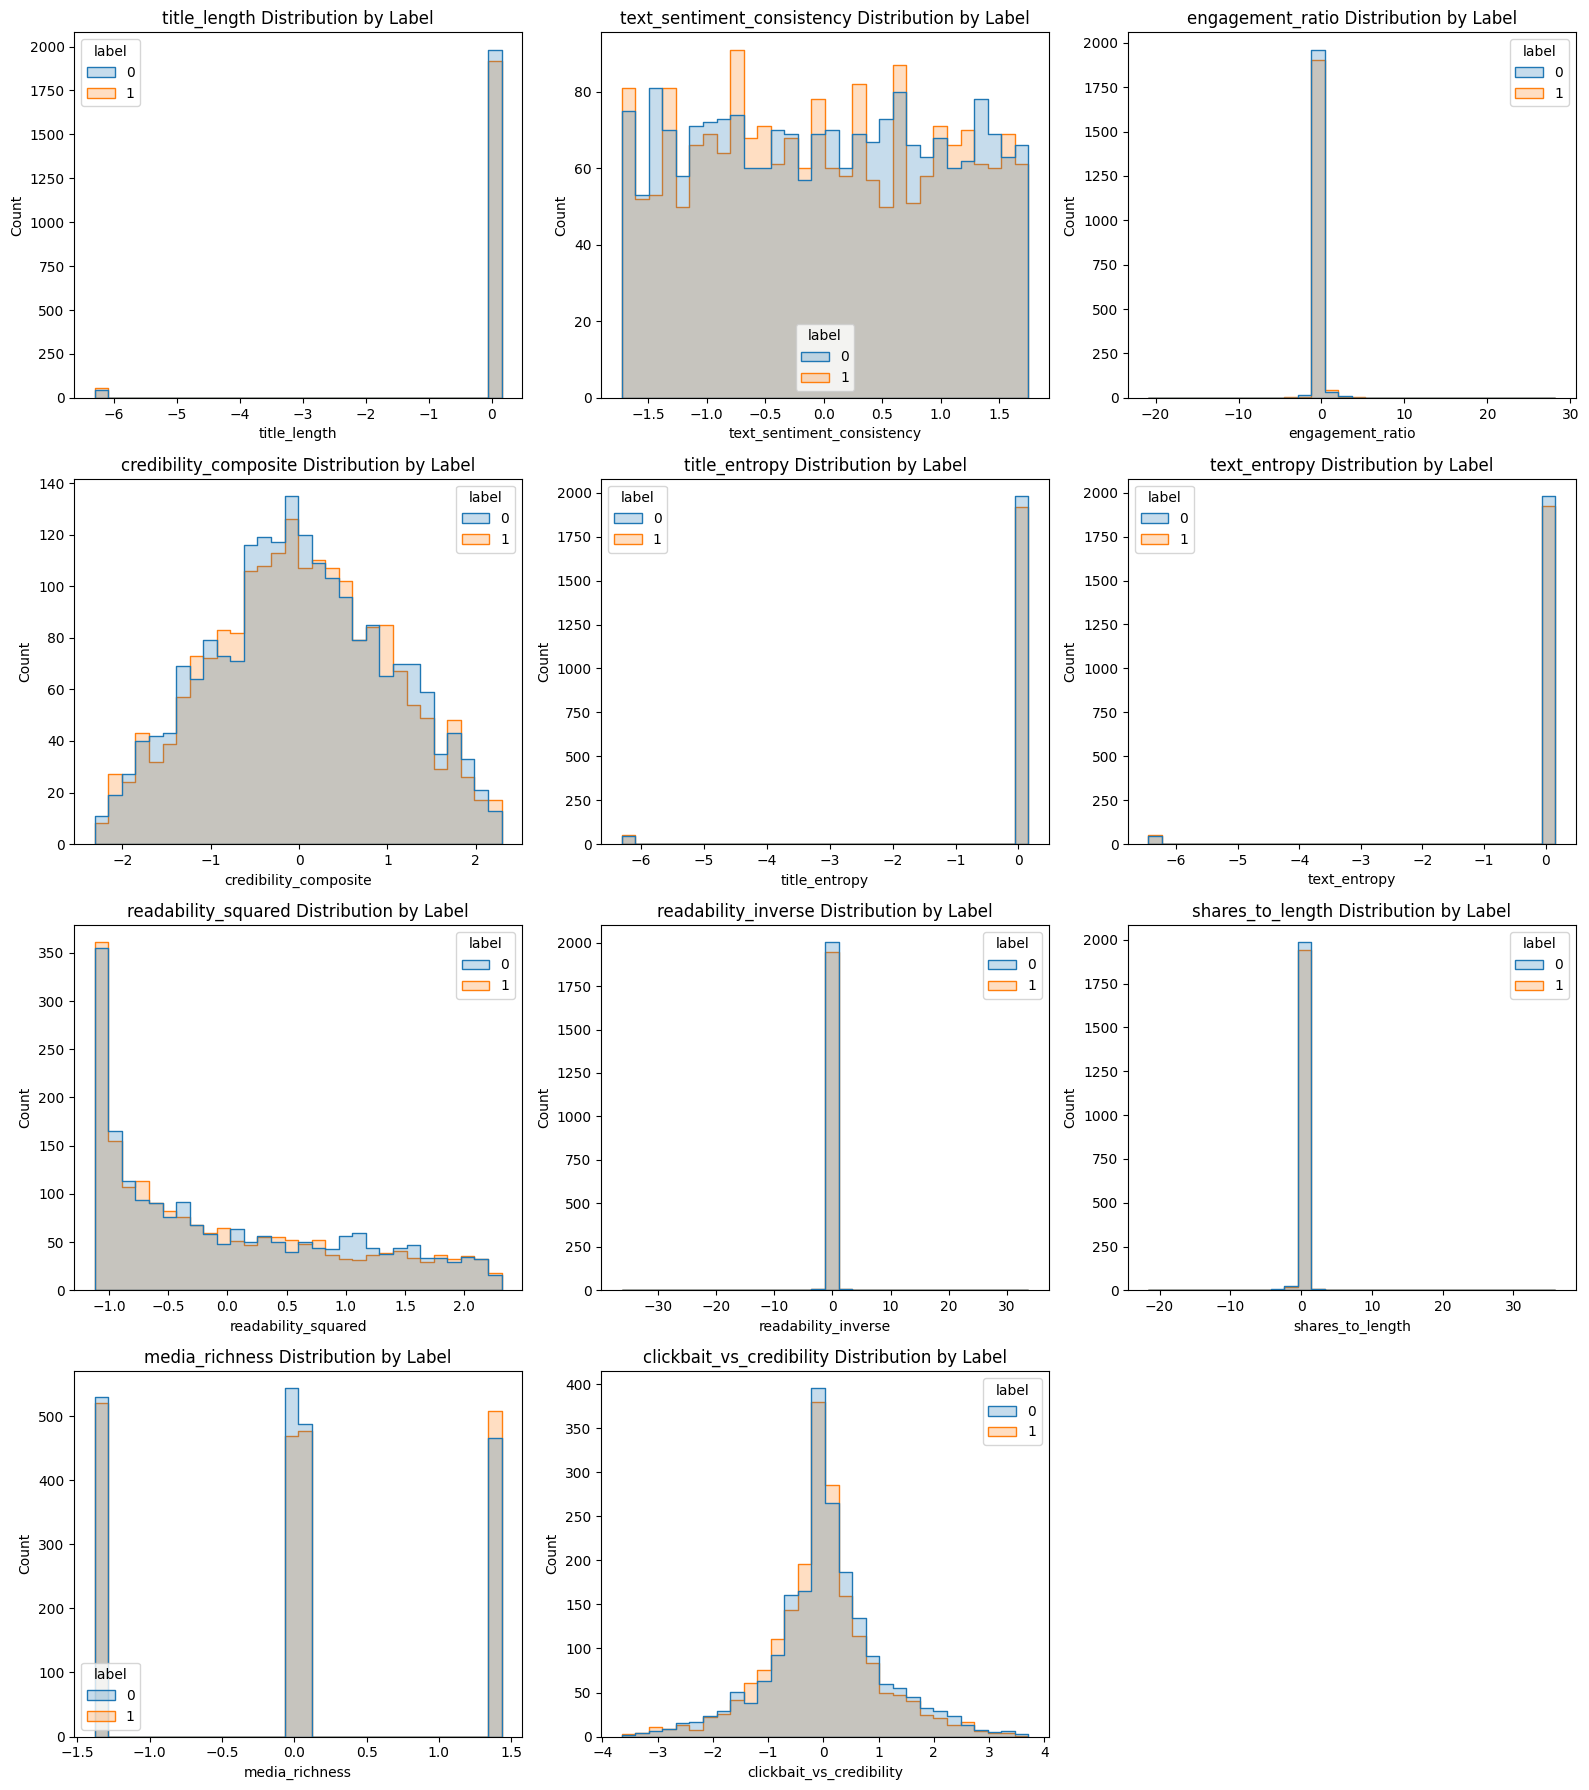

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_list = [
    'title_length', 'text_sentiment_consistency', 'engagement_ratio', 'credibility_composite',
    'title_entropy', 'text_entropy', 'readability_squared', 'readability_inverse',
    'shares_to_length', 'media_richness', 'clickbait_vs_credibility'
]

plt.figure(figsize=(16, 18))
for i, col in enumerate(feature_list, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df, x=col, hue='label', bins=30, element='step')
    plt.title(f'{col} Distribution by Label')
plt.tight_layout()
plt.show()

# **🤖 6. Model Selection and Evaluation**
We are then going to train and tune classifiers (Logistic Regression, Random Forest, XGBoost) on the 259-feature dataset, targeting >85% accuracy and high recall for Fake news detection.

**🧪 Plan**

Split: 
* 80/20 train-test split

Feature Selection: 
* Top 50 from Random Forest

Models:
* Logistic Regression (baseline, high-dimensional data handler)
* Random Forest (non-linear patterns, interpretable)
* XGBoost (boosted ensemble, good with tabular data)
* Support Vector Machine (SVC) (maximizes margin between classes)
* Gradient Boosting Classifier (sklearn) (alternative boosting option to XGBoost)
* MLPClassifier (Neural Net) (non-linear, learns feature interactions)

Tuning: 
* Grid search on Random Forest (n_estimators, max_depth)

Metrics: 
* Accuracy, precision, recall, F1-score — prioritize recall on Fake class (1)

### 📊 Results 

#### Model Performance

- **Logistic Regression**: Accuracy **0.53**, Fake Recall **0.51**
- **Random Forest (Reduced)**: Accuracy **0.49**, Fake Recall **0.48**
- **XGBoost**: Accuracy **0.49**, Fake Recall **0.47**
- **SVM**: Accuracy **0.52**, Fake Recall **0.49**
- **Gradient Boosting**: Accuracy **0.50**, Fake Recall **0.44**
- **MLP (Neural Net)**: Accuracy **0.52**, Fake Recall **0.51**

#### Top Features:
- `engagement_ratio` (**0.044**), `clickbait_vs_credibility` (**0.044**), `shares_to_length` (**0.044**), `credibility_composite` (**0.043**), `plagiarism_score` (**0.044**)


#### 🛠️ Steps Taken to Improve Performance

- **Feature Engineering**: Introduced 9 new features like:
  - `title_length` (clickbait proxy)
  - `engagement_ratio` (virality signal)
  - `credibility_composite` (average of trust and reputation)
  - `clickbait_vs_credibility` (mismatch indicator)
  - `media_richness` (presence of images/videos)

- **Scaling & Reduction**: Reduced from 268 → 50 top features via Random Forest

- **Model Tuning**: Grid search on Random Forest hyperparameters

- **Model Variety**: Tested Logistic Regression, XGBoost, RF, SVM, Gradient Boosting, and MLP


#### ⚠️ Challenges & Insights

- **Feature Overlap**: Fake articles mimic Real ones—little signal in sentiment, word/char counts, or metadata
- **Text Vectorization Weakness**: TF-IDF of title/text (200 features) didn't capture style, sarcasm, tone
- **High Dimensionality**: 268 features vs. 3,200 train samples → diluted signals, overfitting risk
- **Data Noise**: Odd skews (e.g., BBC, Snopes sometimes marked Fake) suggest synthetic or mislabeled data
- **Model Ceiling**: All models plateaued near random (50–53%)—even with advanced tuning and engineering

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd

In [41]:
# train test split
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Feature selection using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = importances.head(50).index

In [43]:
# Reduce features
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

In [44]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, max_depth=20, n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP (Neural Net)': MLPClassifier(max_iter=500)
}

In [45]:
# Train & evaluate
for name, model in models.items():
    model.fit(X_train_reduced, y_train)
    y_pred = model.predict(X_test_reduced)
    print(f"\n{name} Results:\n", classification_report(y_test, y_pred))

# Feature importance
print("\nTop 10 Features:\n", importances.head(10))


Logistic Regression Results:
               precision    recall  f1-score   support

           0       0.54      0.55      0.55       411
           1       0.52      0.51      0.51       389

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.53      0.53      0.53       800


Random Forest Results:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51       411
           1       0.48      0.48      0.48       389

    accuracy                           0.49       800
   macro avg       0.49      0.49      0.49       800
weighted avg       0.49      0.49      0.49       800


XGBoost Results:
               precision    recall  f1-score   support

           0       0.51      0.52      0.51       411
           1       0.48      0.47      0.47       389

    accuracy                           0.49       800
   macro avg       0.49      0.49      0.49       800

## 📌 Conclusion

This fake news detection project aimed to classify 4,000 news articles as either **Fake** or **Real** by leveraging a combination of metadata, sentiment scores, TF-IDF from text fields, and newly engineered features. The project followed a full machine learning pipeline, including EDA, preprocessing, feature engineering, model training, evaluation, and interpretation.

Despite these efforts, model performance plateaued between **50–53% accuracy**, barely above random guessing. This result reflects both **the complexity of the task** and **the limitations of the dataset**.

### Key Takeaways:
- The **feature overlap** between Fake and Real news articles—across sentiment, readability, metadata, and even share metrics—made it difficult for classifiers to draw strong boundaries.
- **TF-IDF vectorization**, while popular, was not enough to capture nuances in tone, satire, or style—factors often critical to identifying Fake news.
- **Feature engineering** added interpretability and domain-relevant signals (e.g., `clickbait_vs_credibility`, `engagement_ratio`) but did not significantly improve generalization.
- Even **non-linear and ensemble models (e.g., XGBoost, MLP)** failed to capitalize on the added features, likely due to high dimensionality and subtle or noisy patterns in the data.

### Future Directions:
To improve performance in future iterations of this project, the following steps are recommended:

- 🔁 **Use transformer-based models** like **BERT**, **RoBERTa**, or **DistilBERT**, which can better understand context, sarcasm, and tone in unstructured text.
- 🔍 **Incorporate linguistic features** such as **n-grams**, **part-of-speech tags**, **sentiment trajectories**, or **readability complexity curves**.
- 📊 **Leverage unsupervised topic modeling** (e.g., LDA) or **semantic clustering** to capture deeper content themes.
- 🧼 **Improve data quality**: Manually audit or filter questionable labels, especially in edge cases where reputable sources (e.g., BBC) are marked Fake.
- 📈 **Expand dataset size**: More examples would help mitigate overfitting and better train complex models.

In conclusion, **detecting fake news is not just a classification problem—it’s a data quality, representation, and context understanding challenge**. This project reinforces the need for richer features, deeper models, and cleaner data in building robust fake news detection systems.